In [14]:
# load libraries, set seed
library(tidyverse)
library(tidymodels)
install.packages("GGally")
install.packages("kknn")
library(kknn)
library(GGally)
set.seed(3)

Warning message in install.packages("GGally"):
“installation of package ‘GGally’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [16]:
# load and read basketball data
cbb <- read_csv("https://raw.githubusercontent.com/naw333/College-Basketball-Data-Science/main/cbb.csv") |>
        filter(POSTSEASON != "N/A")|>
        mutate(POSTSEASON = as_factor(POSTSEASON)) |>
        mutate(PERC= W/G) 
#cbb

# split data into training and testing sets
cbb_split <- initial_split(cbb, 0.75, POSTSEASON)
cbb_train <- training(cbb_split) 
cbb_test <- testing(cbb_split)
nrow(cbb_train)

Rows: 3523 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): TEAM, CONF, POSTSEASON, SEED
dbl (20): G, W, ADJOE, ADJDE, BARTHAG, EFG_O, EFG_D, TOR, TORD, ORB, DRB, FT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 509

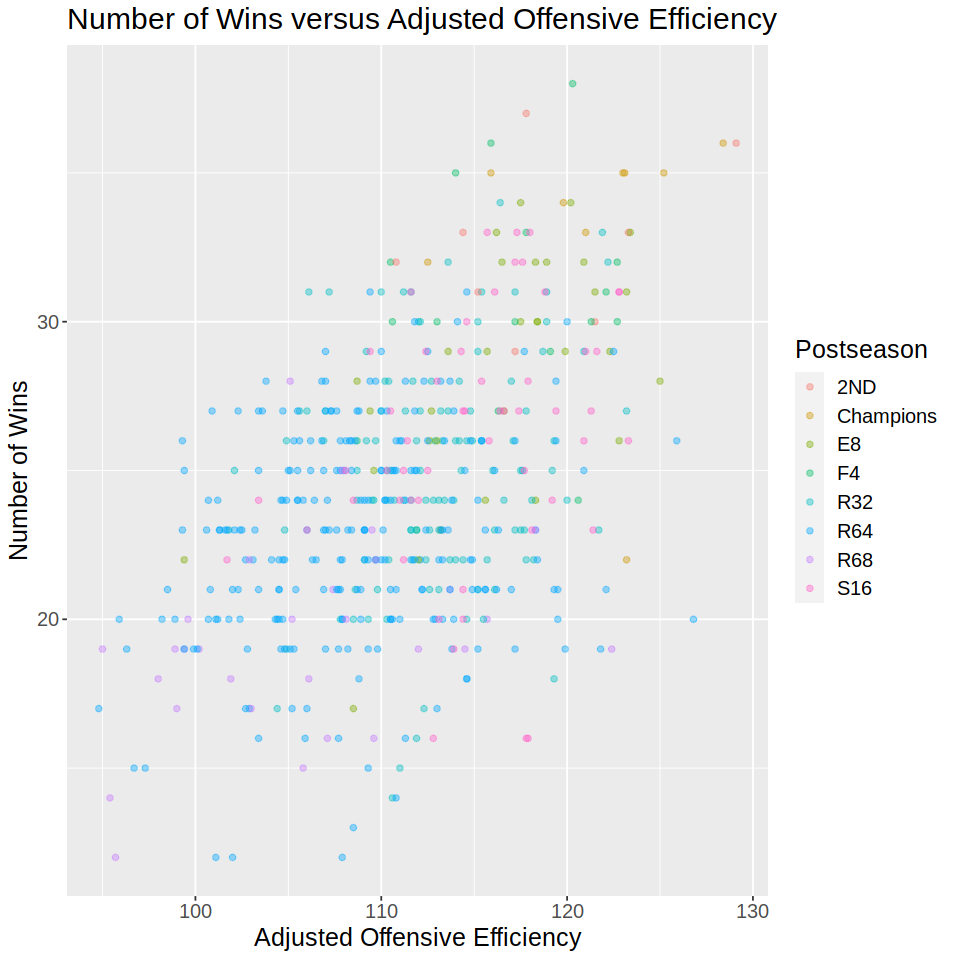

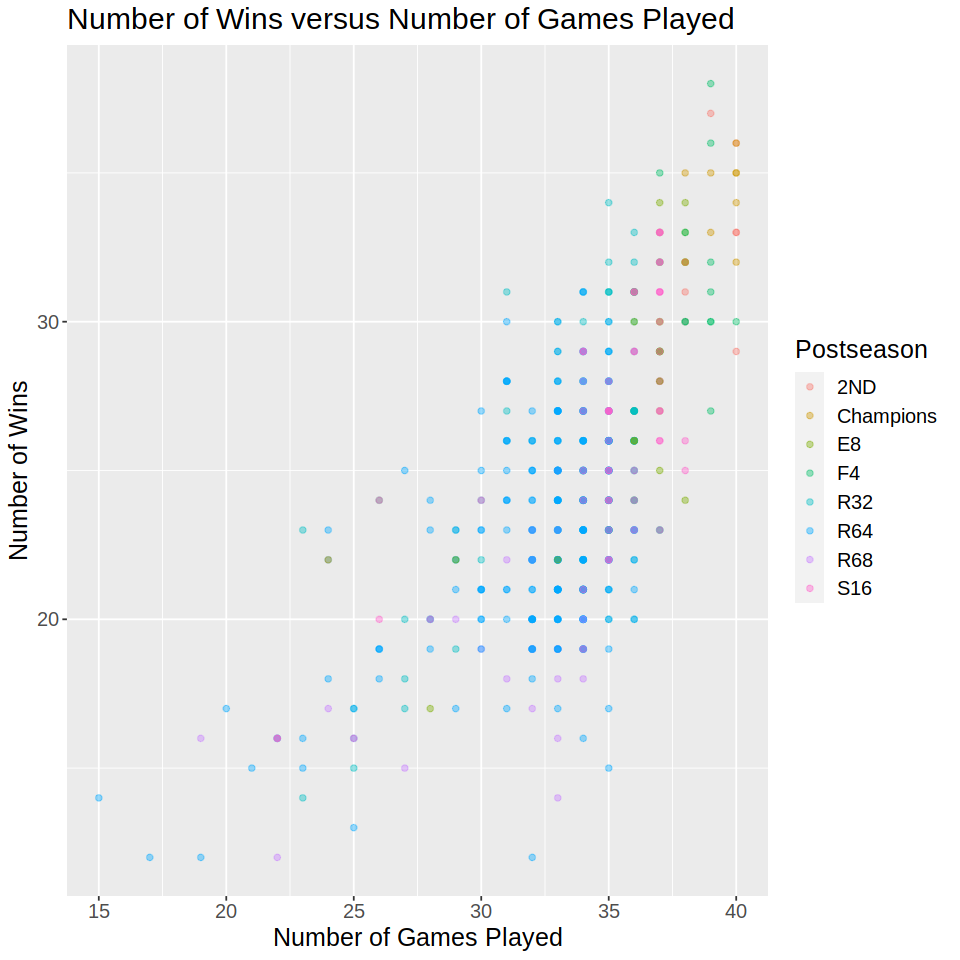

In [17]:
# preliminary analysis:

options(repr.plot.width = 8, repr.plot.height = 8)

# ggpairs plot comparing all variables
pairs_plot <- cbb_train |>
            filter(POSTSEASON != "N/A") |>
            select(G, W, ADJOE, ADJDE, TOR, `3P_O`) |>
            ggpairs(cardinality_threshold = NULL)
#pairs_plot

# W vs. ADJOE
cbb_plot1 <- cbb_train |>
            filter(POSTSEASON != "N/A") |>
            ggplot(aes(x = ADJOE, y = W, color = POSTSEASON)) +
                geom_point(alpha = 0.4) +
                labs(x = "Adjusted Offensive Efficiency",
                    y = "Number of Wins",
                    color = "Postseason") +
                ggtitle("Number of Wins versus Adjusted Offensive Efficiency") +
                theme(text = element_text(size = 15))
cbb_plot1

# W vs. G
cbb_plot2 <- cbb_train |>
            filter(POSTSEASON != "N/A") |>
            ggplot(aes(x = G, y = W, color = POSTSEASON)) +
                geom_point(alpha = 0.4) +
                labs(x = "Number of Games Played",
                    y = "Number of Wins",
                    color = "Postseason") +
                ggtitle("Number of Wins versus Number of Games Played") +
                theme(text = element_text(size = 15))
cbb_plot2

! Fold3: internal:
  There were 30 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '2N...
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 29 ...



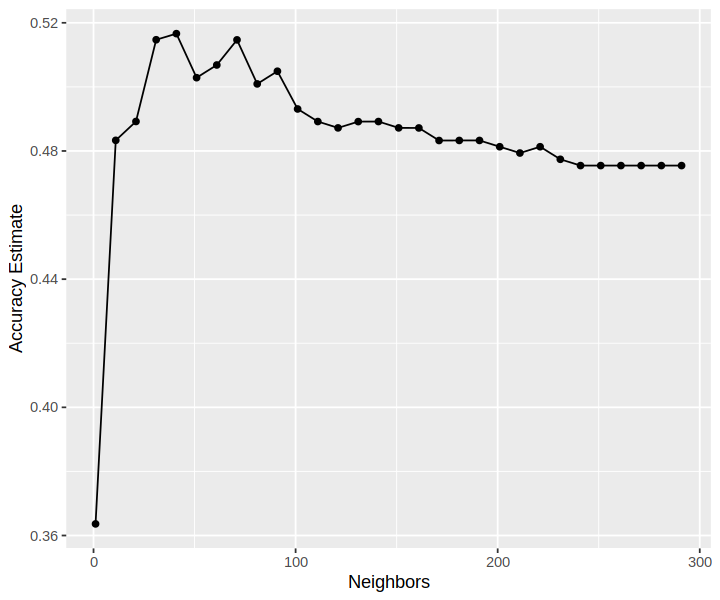

In [18]:
options(repr.plot.height = 5, repr.plot.width = 6)
basket_recipe <- recipe(POSTSEASON ~ PERC + ADJOE + ADJDE + EFG_O + TOR + TORD + ORB + FTR + `2P_D` + `3P_D` + ADJ_T, data = cbb_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors()) 

basket_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
          set_engine("kknn") |>
          set_mode("classification")
    
basket_vfold <- vfold_cv(cbb_train, v = 5, strata = POSTSEASON)

    basket_workflow <- workflow() |>
          add_recipe(basket_recipe) |>
          add_model(basket_spec)

k_vals <- tibble(neighbors = seq(1, 300, 10))

basket_results <- basket_workflow|>
                        tune_grid(resamples = basket_vfold, grid = k_vals)|>
                        collect_metrics()

accuracies <- basket_results|> filter(.metric == "accuracy")
cross_val_plot <- accuracies|>ggplot(aes(x = neighbors, y=mean)) + 
                                    geom_point()+
                                    geom_line()+
                                    labs(x = "Neighbors", y = "Accuracy Estimate")
cross_val_plot

In [19]:
#k value best at 41?
mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 51)|>
                                set_engine("kknn")|>
                                set_mode("classification")
mnist_fit <- workflow()|>
                add_recipe(basket_recipe)|>
                add_model(mnist_spec) |>
                fit(data = cbb_train)
mnist_predictions <- mnist_fit |>
                        predict(cbb_test)|>
                        bind_cols(cbb_test)
mnist_metrics <- mnist_predictions |>
                metrics(truth = POSTSEASON, estimate = .pred_class) |>
                filter(.metric == "accuracy")

mnist_conf_mat <- mnist_predictions |> 
                        conf_mat(truth = POSTSEASON, estimate = .pred_class)

mnist_predictions
mnist_metrics
mnist_conf_mat

.pred_class,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,⋯,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,PERC
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<dbl>
R32,Notre Dame,ACC,38,32,125.3,98.6,0.9401,58.3,47.9,⋯,58.2,47.4,39.0,32.6,63.9,8.6,E8,3,2015,0.8421053
R32,Michigan St.,B10,38,29,119.6,95.3,0.9319,54.5,45.8,⋯,52.1,43.5,39.2,33.2,66.2,6.9,E8,4,2014,0.7631579
R64,Dayton,A10,37,26,113.0,99.1,0.8188,52.4,48.8,⋯,50.4,48.3,37.7,33.2,65.4,0.6,E8,11,2014,0.7027027
S16,Michigan St.,B10,39,32,119.9,91.0,0.9597,55.2,43.9,⋯,54.3,41.9,37.8,31.6,68.6,10.7,F4,2,2019,0.8205128
R32,Oklahoma,B12,37,29,118.2,94.1,0.9326,54.3,47.2,⋯,48.2,45.3,42.2,33.7,70.8,8.0,F4,2,2016,0.7837838
R64,Saint Joseph's,A10,36,28,114.2,97.6,0.8600,51.2,48.1,⋯,52.3,49.2,32.7,31.1,70.9,3.4,R32,8,2016,0.7777778
R32,Rhode Island,A10,35,25,111.1,94.1,0.8717,50.8,45.0,⋯,51.2,45.4,33.3,29.5,67.7,0.4,R32,11,2017,0.7142857
R32,Duke,ACC,37,28,122.1,95.6,0.9436,54.8,47.4,⋯,53.5,48.9,37.9,29.3,69.7,8.6,R32,2,2017,0.7567568
R64,Virginia,ACC,34,23,111.8,86.9,0.9477,52.4,46.1,⋯,49.7,45.1,38.5,31.7,60.3,5.0,R32,5,2017,0.6764706


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4619883


           Truth
Prediction  2ND Champions E8 F4 R32 R64 R68 S16
  2ND         0         0  0  0   0   0   0   0
  Champions   0         0  0  0   0   0   0   0
  E8          0         0  0  0   0   0   0   0
  F4          0         0  0  0   0   0   0   0
  R32         1         1  5  1  10  10   1  12
  R64         1         0  3  1  32  68  10  13
  R68         0         0  0  0   0   0   0   0
  S16         0         0  0  1   0   0   0   1